In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print('X:',X.shape)
print('y:',y.shape)

X: (70000, 784)
y: (70000,)


In [3]:
import matplotlib.pyplot as plt

some_digit = X[0,:]
some_digit_image = some_digit.reshape(28,28)

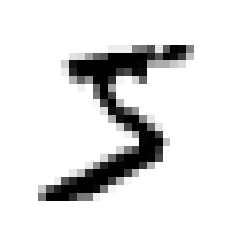

In [4]:
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We will focus on trying to identify one digit - the number 5. Therefore we will only discriminate two classes, 5 and not 5.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Accuracy

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

A result of over 95% accuracy may sound impressive. But considering around 10% of our images are 5's, classifying ALL images as not-5 would already give us a 90% accuracy.

### Confusion Matrix. Precision and Recall. F metric.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, n_jobs=-1)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The confusion matrix displays in rows the real category, and in columns the predicted category.
Therefore its content is given in the next table

 $$  \left( \begin{matrix} \textrm{True Negative} & \textrm{False Positive} \\ \textrm{False Negative} & \textrm{True Positive} \end{matrix} \right) $$
 
More concise metrics are precision and recall. Precision measures the accuracy of positive predictions:

$$ precision = \frac{TP}{TP + FP} $$

With TP and FP the number of true positives and false positives respectively. This metric is commonly paired with recall, also called sensitivity or true positive rate: this is the ratio of positive instances that are correctly detected by the classifier

$$ recall = \frac{TP}{TP + FN} $$

With FN the number of false negatives

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


The harmonic mean of precision and recall is called the $F_{1}$ score

$$ F_{1} = \frac{2}{\frac{1}{\textrm{precision}} + \frac{1}{\textrm{recall}}} = \frac{TP}{TP+\frac{FN + FP}{2}} $$

In [15]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


This metric favors similar precision and recall, but this may not be desired for every scenario. Unfortunately, you can't have it both ways: increase in precision reduces recall and vice versa. This is called the *precision/recall trade-off*

### Precision/Recall Trade-Off

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [17]:
threshold = 0 # Default for sgd classifier
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

We can use **cross_val_score** returning the decision scores

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3,method='decision_function', n_jobs=-1)

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

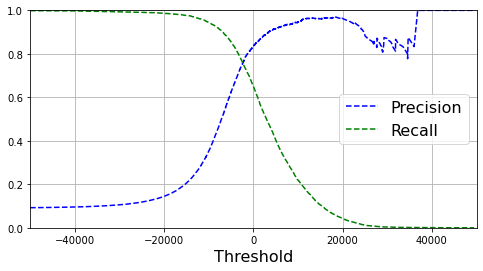

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1],'g--', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

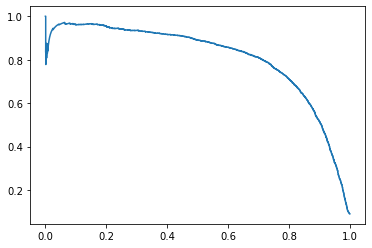

In [22]:
plt.plot(recalls, precisions)
plt.show()

In [23]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

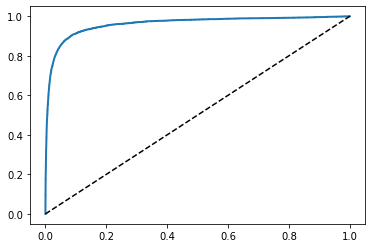

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr,tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method='predict_proba', n_jobs=-1)

In [31]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

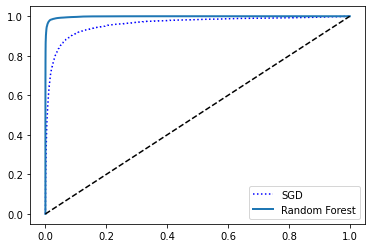

In [32]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [34]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, n_jobs=-1)

print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


## Multiclass Classification

In [35]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

By default SVC uses the OvO strategy. We can also call decision_function() to see the score of each class

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
np.argmax(some_digit_scores)

5

Note in this example we are just lucky the indexes match our classes

We can force a OvR strategy to this SVClassifier with the proper class

In [38]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

Let's try a SGDClassifier

In [40]:
sgd_clf.fit(X_train, y_train)

AttributeError: 'SGDClassifier' object has no attribute 'prefict'

In [41]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

It seems the classifier is pretty confident in its predictions, except maybe for the class 3. We can also evaluate this classifier as usual

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

This score though not bad, can easily be improved by standarizing our features

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

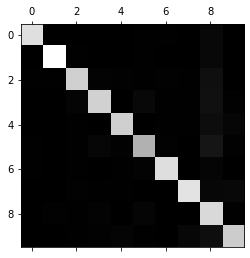

In [58]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
row_sums = conf_mx.sum(axis=1 ,keepdims=True)
norm_conf_mx = conf_mx / row_sums

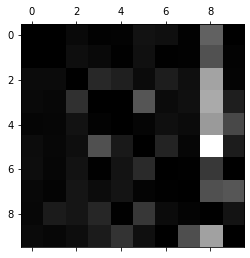

In [62]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

## Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,
cv=3, n_jobs=-1)

In [54]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [69]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

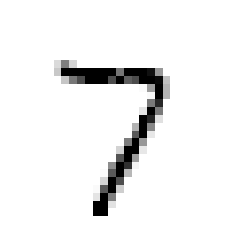

In [70]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

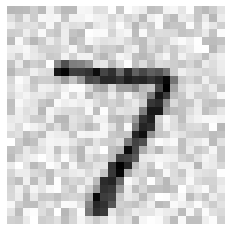

In [71]:
plot_digit(X_test_mod[0])